# Using ARIMA Models For Forecasting Electricity Power Demand

## In this notebook we will:
- Show and introduce our data.
- Clean Data.
- Analyze data to figure its structure like stationary, seasonality, autocorrelation, partial autocorrelation.
- Build ML Model to predict future Electricity Power Demand.

#### Import Packages

In [1]:
from support import *
# , RollingForecastCV, SlidingWindowForecastCV, cross_val_predict
from pmdarima.model_selection import train_test_split
from pmdarima.utils import tsdisplay  # , decomposed_plot
from warnings import filterwarnings
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.preprocessing import LogEndogTransformer, BoxCoxEndogTransformer
from pmdarima.metrics import smape
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(42)
%matplotlib inline
plt.style.use('fivethirtyeight')
# from pmdarima.pipeline import Pipeline
filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### Load our data

In [2]:
# Data download
# ==============================================================================
data = pd.read_csv('vic_elec.csv')
data.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [4]:
# Data preparation
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head()

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True


In [5]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [6]:
# Aggregating in 1D intervals
# ==============================================================================

data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label='right').mean()
data.Holiday = data.Holiday.apply(np.ceil)
data.head()

,Demand,Temperature,Holiday
Time,,,
2012-01-01,3751.442996,21.047727,1.0
2012-01-02,4745.380361,26.578125,1.0
2012-01-03,5739.395602,31.751042,1.0
2012-01-04,5394.902696,24.567708,0.0
2012-01-05,4454.007853,18.191667,0.0


In [10]:
data.Holiday = data.Holiday.astype(int)

In [11]:
data.Holiday.value_counts()

0    1039
1      58
Name: Holiday, dtype: int64

#### Data Information and Number of rows and columns

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2012-01-01 to 2015-01-01
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       1097 non-null   float64
 1   Temperature  1097 non-null   float64
 2   Holiday      1097 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 30.0 KB


#### check null values

In [9]:
data.isna().sum()

Demand         0
Temperature    0
Holiday        0
dtype: int64

##### Summary Statistics

In [10]:
data.describe()

,Demand,Temperature,Holiday
count,1097.000000,1097.000000,1097.000000
mean,4664.718977,16.269425,0.052871
std,518.129963,4.901892,0.223879
min,3340.564754,6.570833,0.000000
25%,4320.722537,12.537500,0.000000
50%,4657.565292,15.700000,0.000000
75%,4981.148367,19.161458,0.000000
max,7322.074134,36.314583,1.000000


## Pre-modeling analysis

#### Check Seasonality

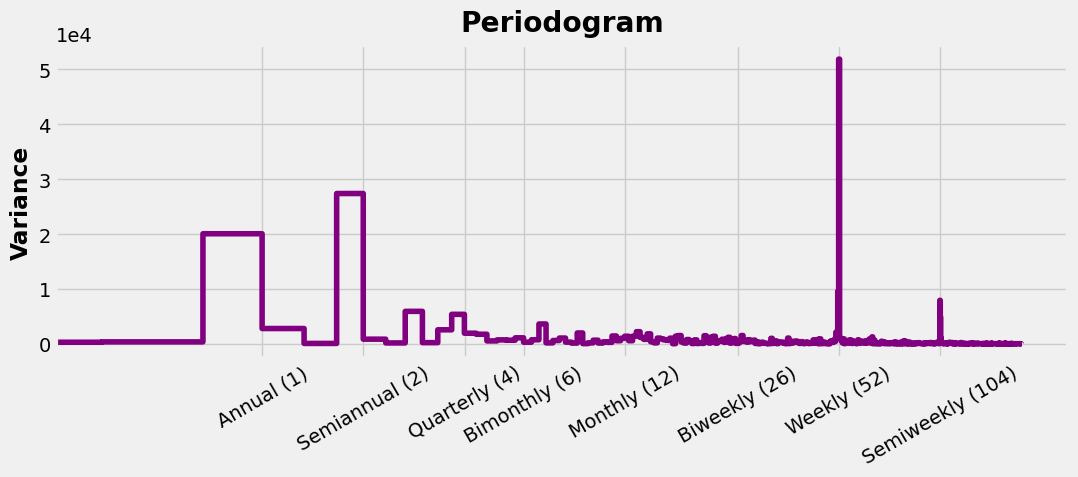

In [45]:
plot_periodogram(data['Demand']);

***Strong Seasonality Annual and Weekly***

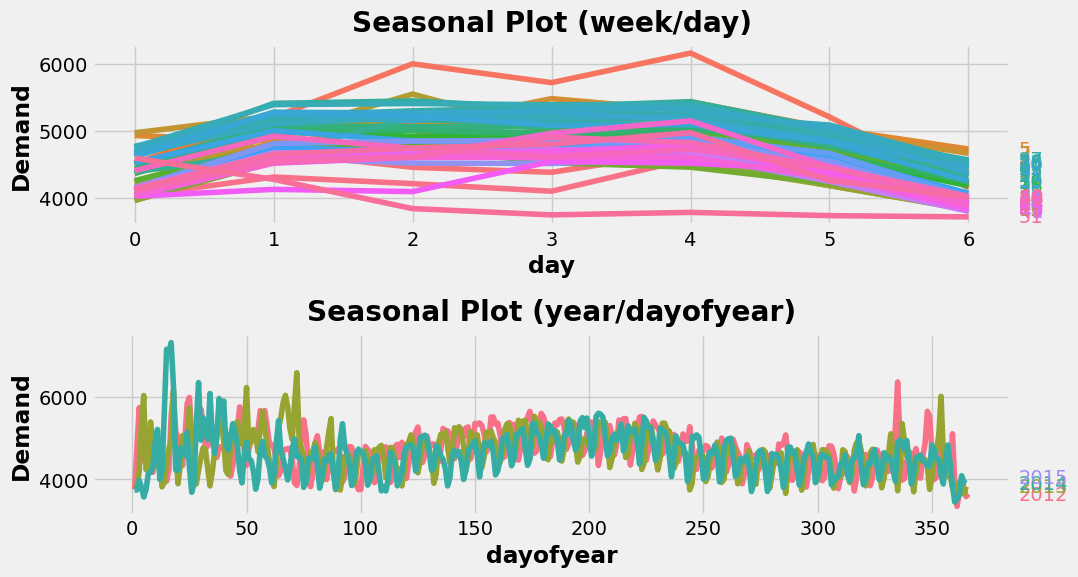

In [12]:
X = data.copy()
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Demand", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Demand", period="year", freq="dayofyear", ax=ax1)

***- It is observed that there is a lower demand values during the weekend.***

***- It is observed that there is an annual seasonality, with higher demand values in June, July, and August, and with high demand peaks in November, December, January, February, and March.***

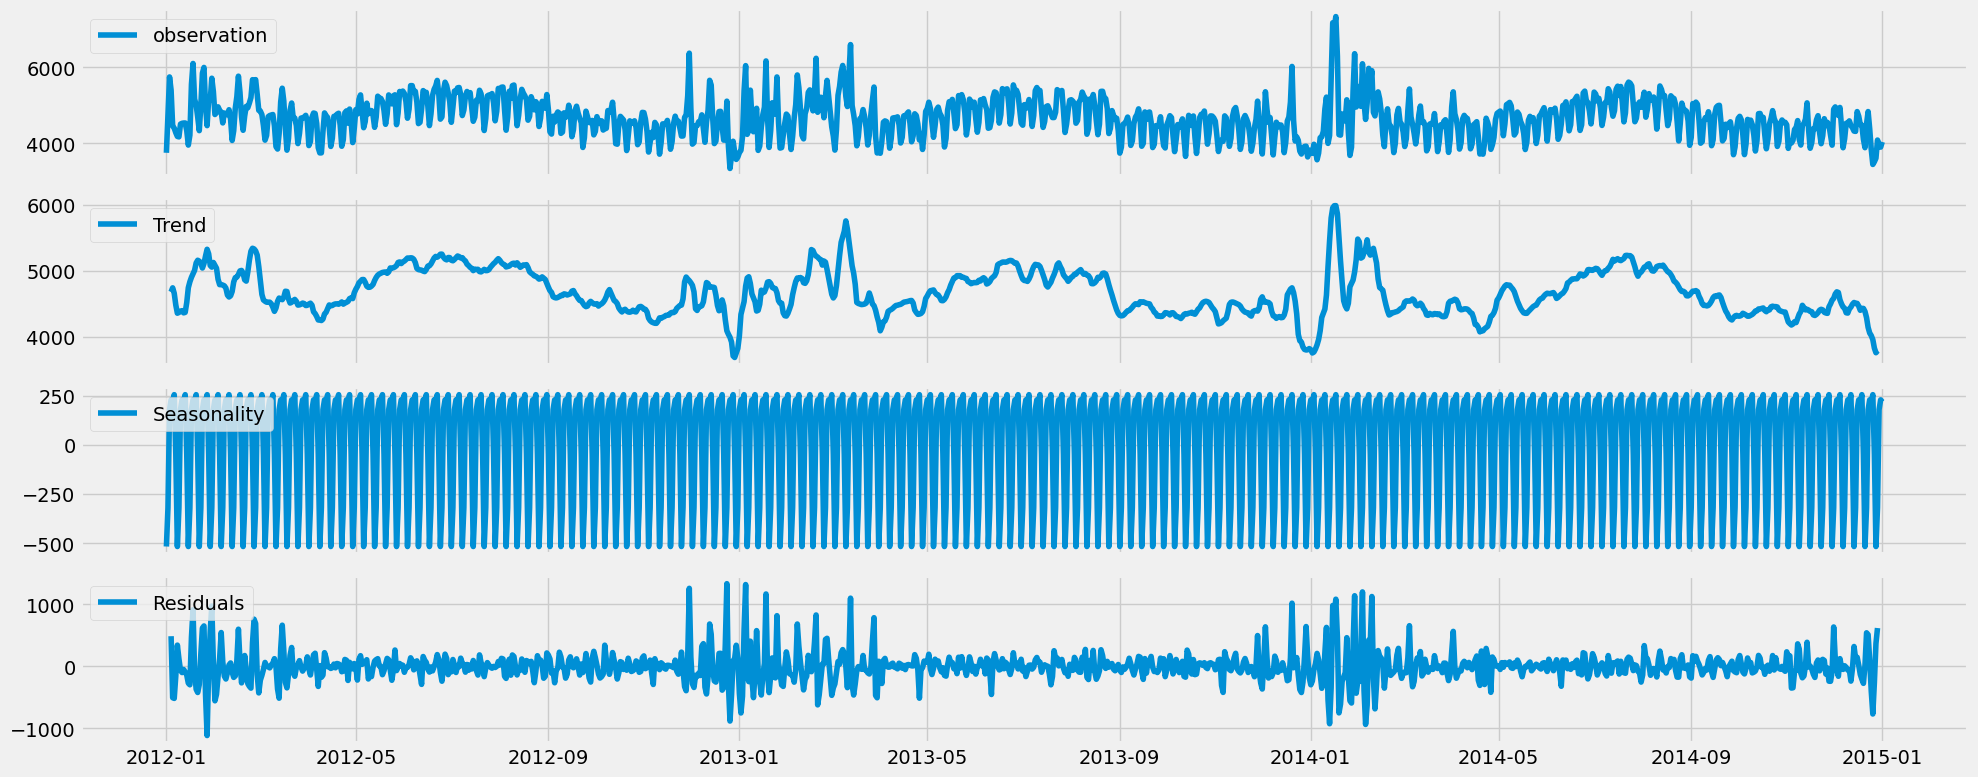

In [13]:
decompose(data.Demand)

- ***There is no trend in our data.***
- ***There is volatility in the beginning of every year.***

### Data splitting

In [33]:
# Split data and use one month for testing
y_train, y_test = train_test_split(data, test_size=30)

# to use index in plots
train, test = data.iloc[:-30, :], data.iloc[-30:, :]

print(f'All Data Rows Is: {data.shape[0]}, Data Train Rows Is: {y_train.shape[0]}, Data Test Rows Is: {y_test.shape[0]}')

All Data Rows Is: 1097, Data Train Rows Is: 1067, Data Test Rows Is: 30


- ARIMA model has 3 core hyper-parameters, known as 'order'.
- p: The order of the auto-regressive (AR) model (i.e., the number of lag observations)
- d: The degree of differencing.
- q: The order of the moving average (MA) model. This is essentially the size of the 'window' function over your time series data

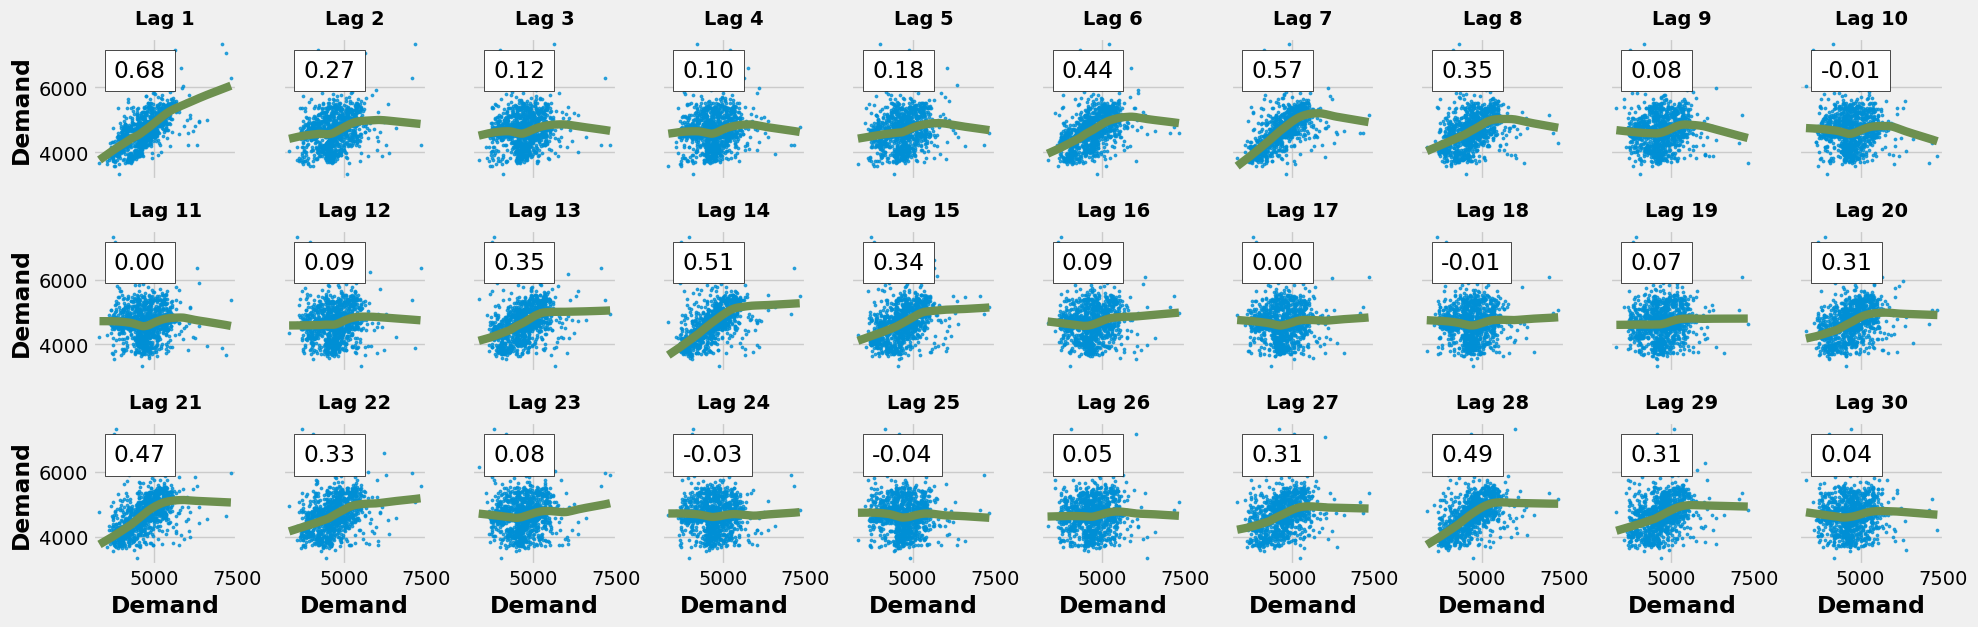

In [15]:
_ = plot_lags(y_train.Demand, lags=30, nrows=3)  # q 7 is good

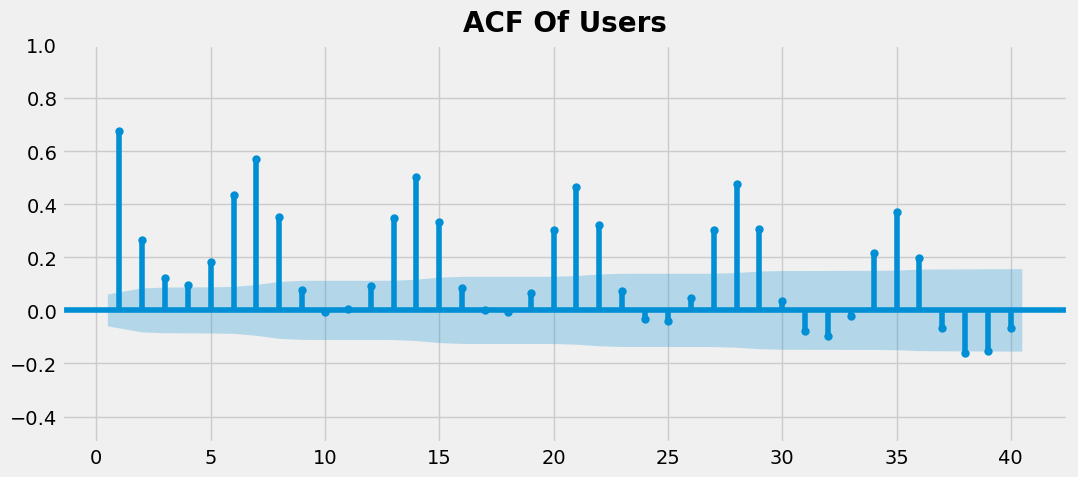

In [46]:
plot_acf(y_train.Demand, zero=False, lags=40)
plt.title("ACF Of Users", size=20)
plt.ylim(-0.5, 1);

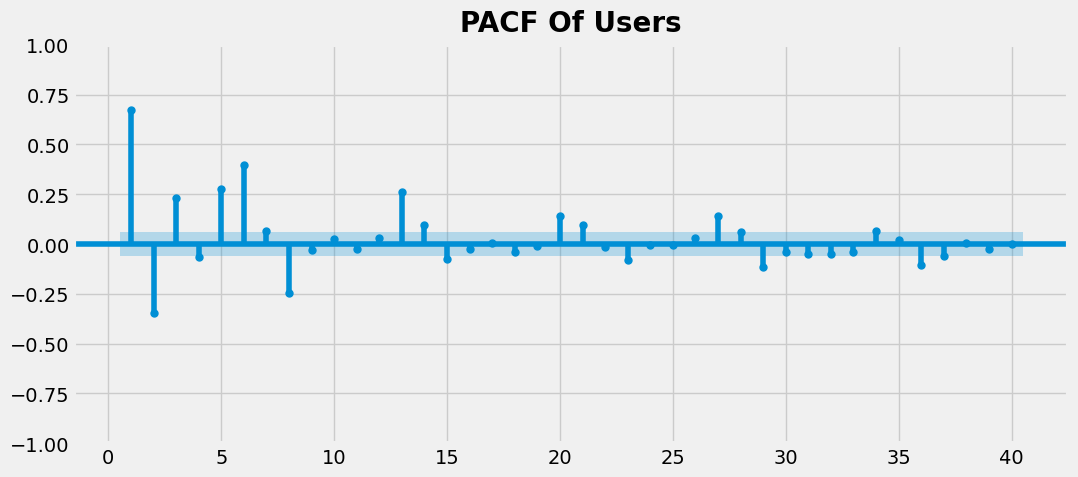

In [47]:
plot_pacf(y_train.Demand, zero=False, lags=40)
plt.title("PACF Of Users", size=20);

***The autocorrelation and partial autocorrelation plots show a clear association between one day's demand and previous days, as well as between one day's demand and the same day's demand on previous days. This type of correlation is an indication that autoregressive models can work well.***

#### Check data stationary

In [18]:
# shuld be less than 0.05 to be stationary
a = adfuller(y_train.Demand)
print(f'adfuller Pvalue = {a[1].round(2)}\nlags = {a[2]}')
if a[1] < 0.05:
    print('Our Data Is Stationary according to ADFuller Test', '\n')
else:
    print('Our Data Is Nonstationary according to ADFuller Test', '\n')

# shuld be more than 0.05 to be stationary and normally distributed
n = normaltest(y_train.Demand)[1].round(2)
print(f'normaltest Pvalue = {n}')
if n > 0.05:
    print('Our Data Is Stationary according to Normal Test')
else:
    print('Our Data Is Nonstationary according to Normal Test')

adfuller Pvalue = 0.0
lags = 22
Our Data Is Stationary according to ADFuller Test 

normaltest Pvalue = 0.0
Our Data Is Nonstationary according to Normal Test


### Estimating the differencing term.

In [19]:
# We will check d
diffs_number(data=y_train.Demand, alpha=0.05)

Pvalue Is: 0.01
Should we difference at the alpha=0.05? True
Number of differences using kpss test Is: 1
Number of differences using adf test Is: 0


# Fitting our model

In [35]:
# Fitting auto_arima
auto = pm.auto_arima(y=y_train.Demand,
                     X=y_train.drop('Demand', axis=1),
                     m=7,
                     # stepwise=True,
                     suppress_warnings=True,
                     error_action="ignore",
                     # max_order=None,
                     trace=True,
                     n_jobs=-1,
                     #trend='ct',
                     out_of_sample_size=60,
                     random_state=42)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15757.150, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=15231.478, Time=1.61 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=15452.413, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=15755.156, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=15740.322, Time=0.42 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=15109.999, Time=1.78 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=15098.501, Time=2.47 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=15228.985, Time=1.29 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=15104.703, Time=2.94 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Ti

In [36]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1067
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -7543.012
Date:                           Wed, 19 Apr 2023   AIC                          15096.024
Time:                                   07:50:15   BIC                          15120.882
Sample:                                        0   HQIC                         15105.443
                                          - 1067                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            40.1099      1.697     23.640      0.000      36.784      43.435
x2          -374.7218     37.483     -9.997      0.000    -448.188    -301.256
ar.S.L7        0.4123      0.024     16.970      0.000       0.365       0.460
ar.S.L14       0.3460      0.026     13.404      0.000       0.295       0.397
sigma2      8.389e+04   3130.064     26.801      0.000    7.78e+04       9e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               216.23
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.23
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Get prediction for Train Data.

In [37]:
# y_pred_train = auto.predict_in_sample()
y_pred_train = pd.DataFrame(auto.predict_in_sample(
    X=y_train.drop('Demand', axis=1)), index=train.index)
print(
    f'Mean Absolute Error For Train Data Is: {mae(y_train.Demand, y_pred_train)}')
print(
    f'Summetric Mean Absolute Error Percentage For Train Data Is: {smape(y_train.Demand, y_pred_train)}')

Mean Absolute Error For Train Data Is: 218.42025589514367
Summetric Mean Absolute Error Percentage For Train Data Is: 4.734806235858657


#### Viewing Prediction for Train Data.

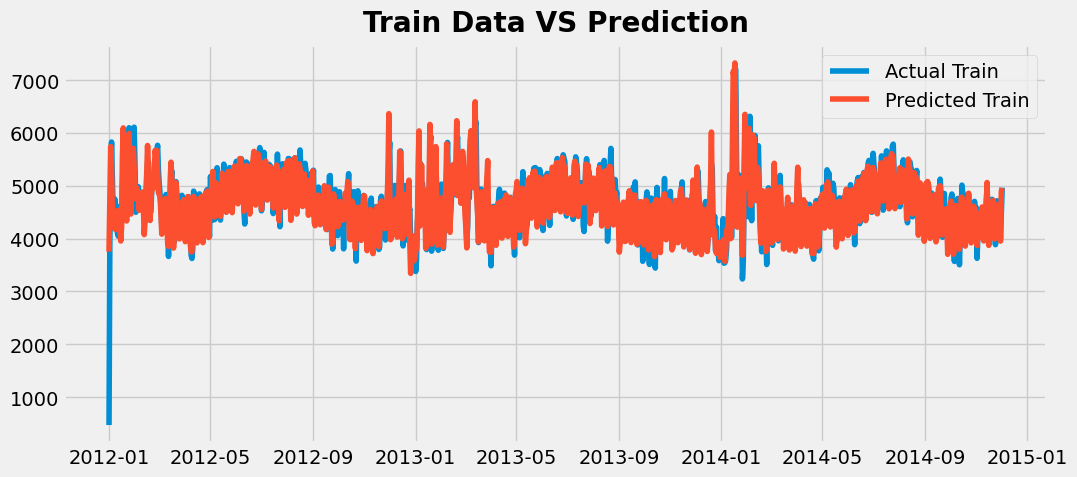

In [39]:
# plot expected vs actual
# plt.figure(figsize=(20,8))
plt.plot(y_pred_train, label='Actual Train')
plt.plot(train.Demand, label='Predicted Train')
plt.title('Train Data VS Prediction')
plt.legend();

#### Updating the model and get prediction for Test Data.

In [40]:
forecasts = ts_1step(y_label='Demand', model=auto, y_test=y_test, exo=True)

In [41]:
y_pred_test = pd.DataFrame(forecasts, index=test.index)

print(
    f'Mean Absolute Error For Test Data Is: {mae(y_test.Demand, y_pred_test)}')
print(
    f'Summetric Mean Absolute Error Percentage For Test Data Is: {smape(y_test.Demand, y_pred_test)}')

Mean Absolute Error For Test Data Is: 121.9589701958039
Summetric Mean Absolute Error Percentage For Test Data Is: 2.942540615100554


#### Viewing forecasts for Test Data.

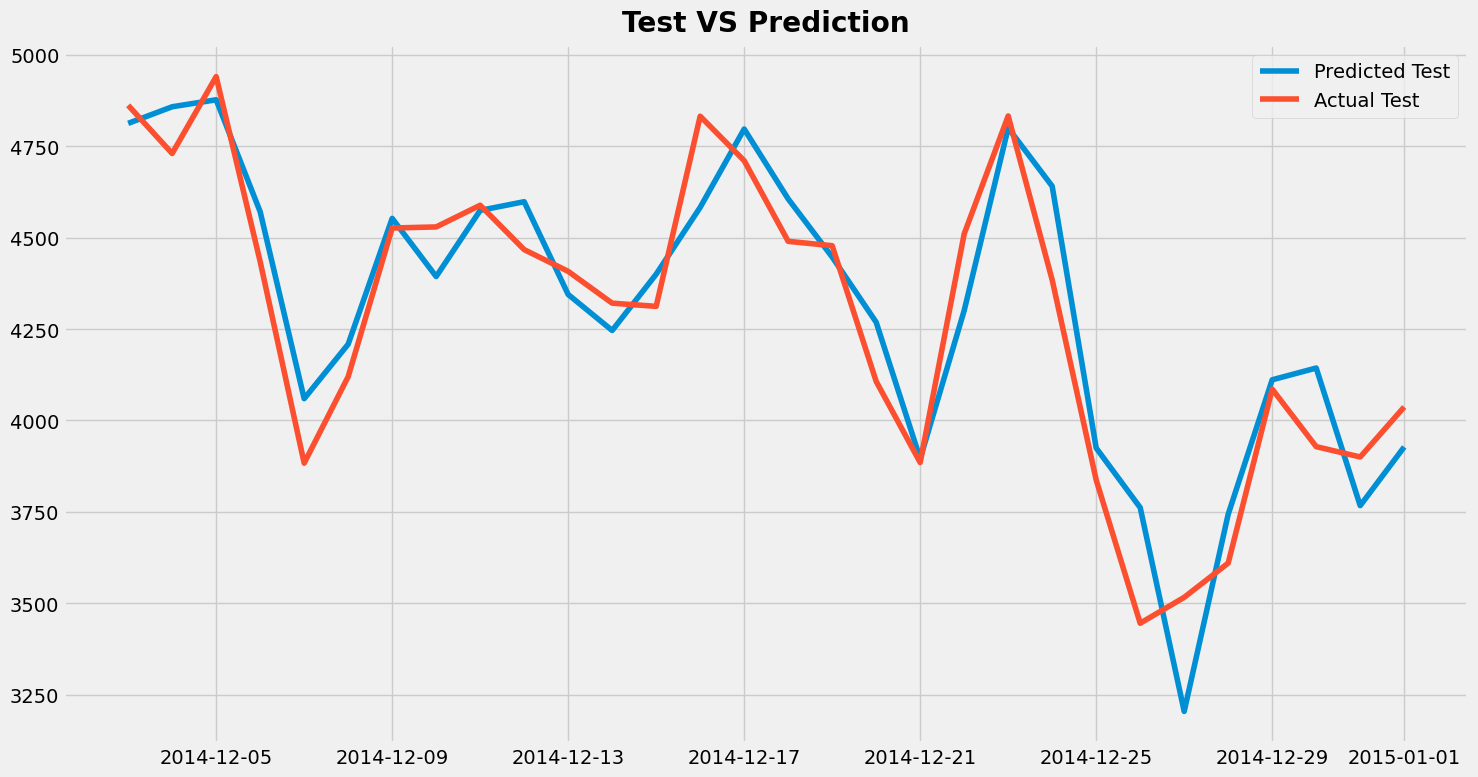

In [42]:
# plot expected vs actual
plt.figure(figsize=(15, 8))
plt.plot(y_pred_test, label='Predicted Test')
plt.plot(test.Demand, label='Actual Test')
plt.title('Test VS Prediction')
plt.legend();

# Model diagnosis.

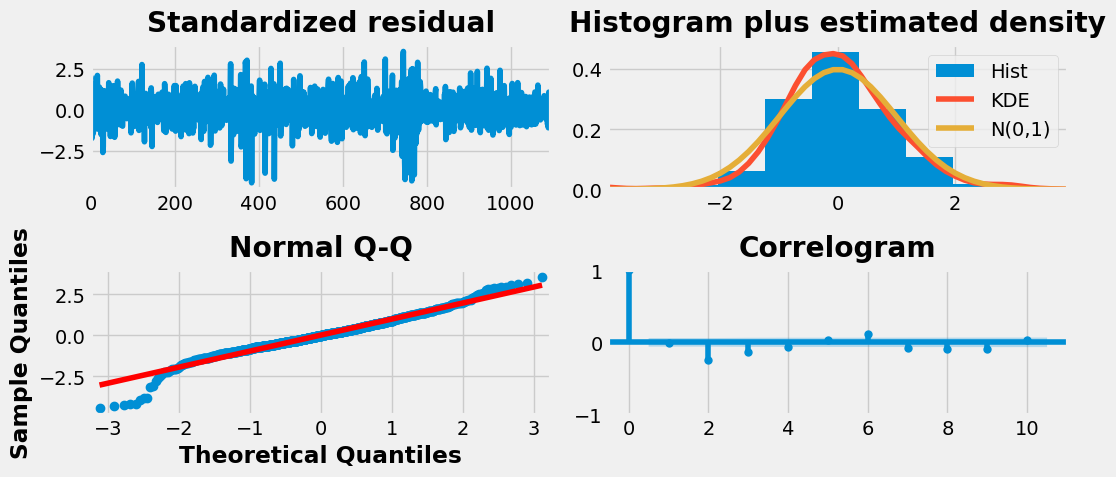

In [43]:
auto.plot_diagnostics();

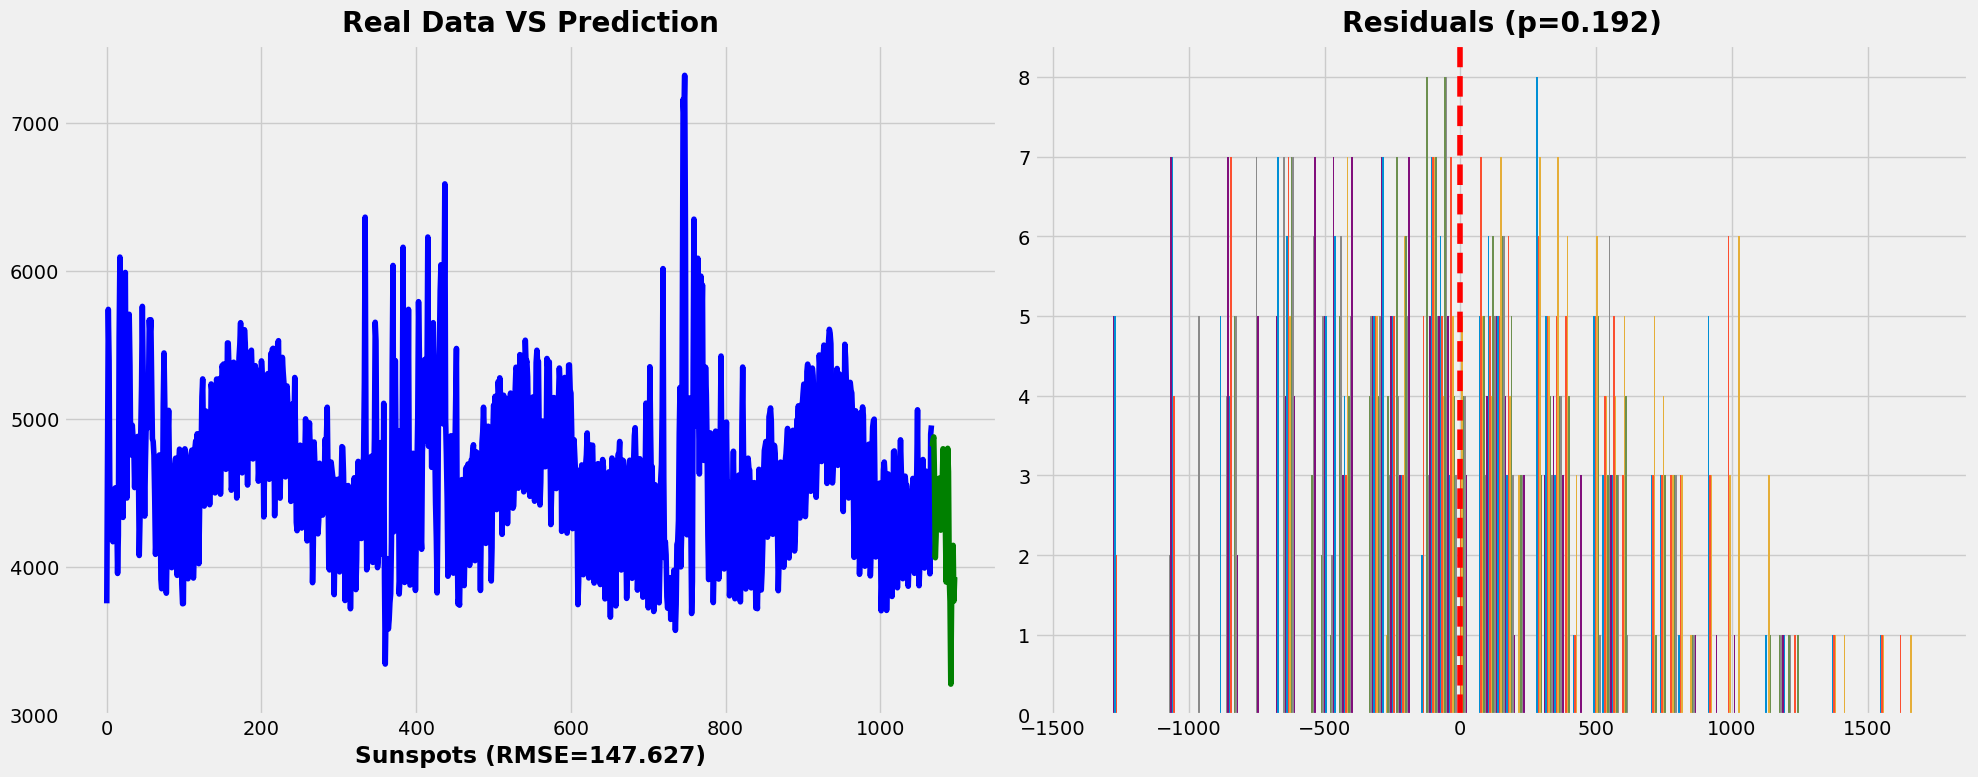

In [44]:
# Residuals should be normally distributed (p>0.05)
plot_forecasts(y_train=y_train.Demand.values, y_test=y_test.Demand.values,
               forecasts=y_pred_test.values, title='Real Data VS Prediction')

***Residuals are normally distributed (p>0.05), so our model seems to perform well.***

# Prophet model

In [15]:
data.columns

Index(['Demand', 'Temperature', 'Holiday'], dtype='object')

In [13]:
from prophet import Prophet

In [16]:
df = data.copy()
df.reset_index(inplace=True)

df.columns = ['ds', 'y', 'Temperature', 'Holiday']

# create test dataset, remove last 30 days
y_train = df.drop(df.index[-30:])
y_test = df.iloc[-30:, :]

In [18]:
model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('Holiday')
model.fit(y_train)

10:45:28 - cmdstanpy - INFO - Chain [1] start processing
10:45:28 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
y_pred_train = model.predict()

print(
    f'Mean Absolute Error For Test Data Is: {mae(y_train.y, y_pred_train.yhat)}')
print(
    f'Summetric Mean Absolute Error Percentage For Test Data Is: {smape(y_train.y, y_pred_train.yhat)}')

Mean Absolute Error For Test Data Is: 215.18313654555504
Summetric Mean Absolute Error Percentage For Test Data Is: 4.562523668906194


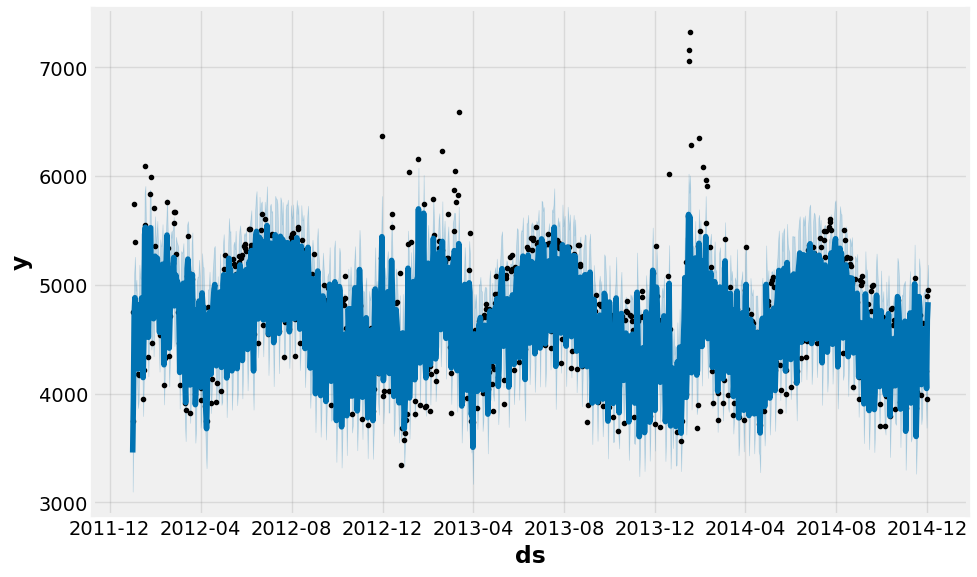

In [20]:
model.plot(y_pred_train);

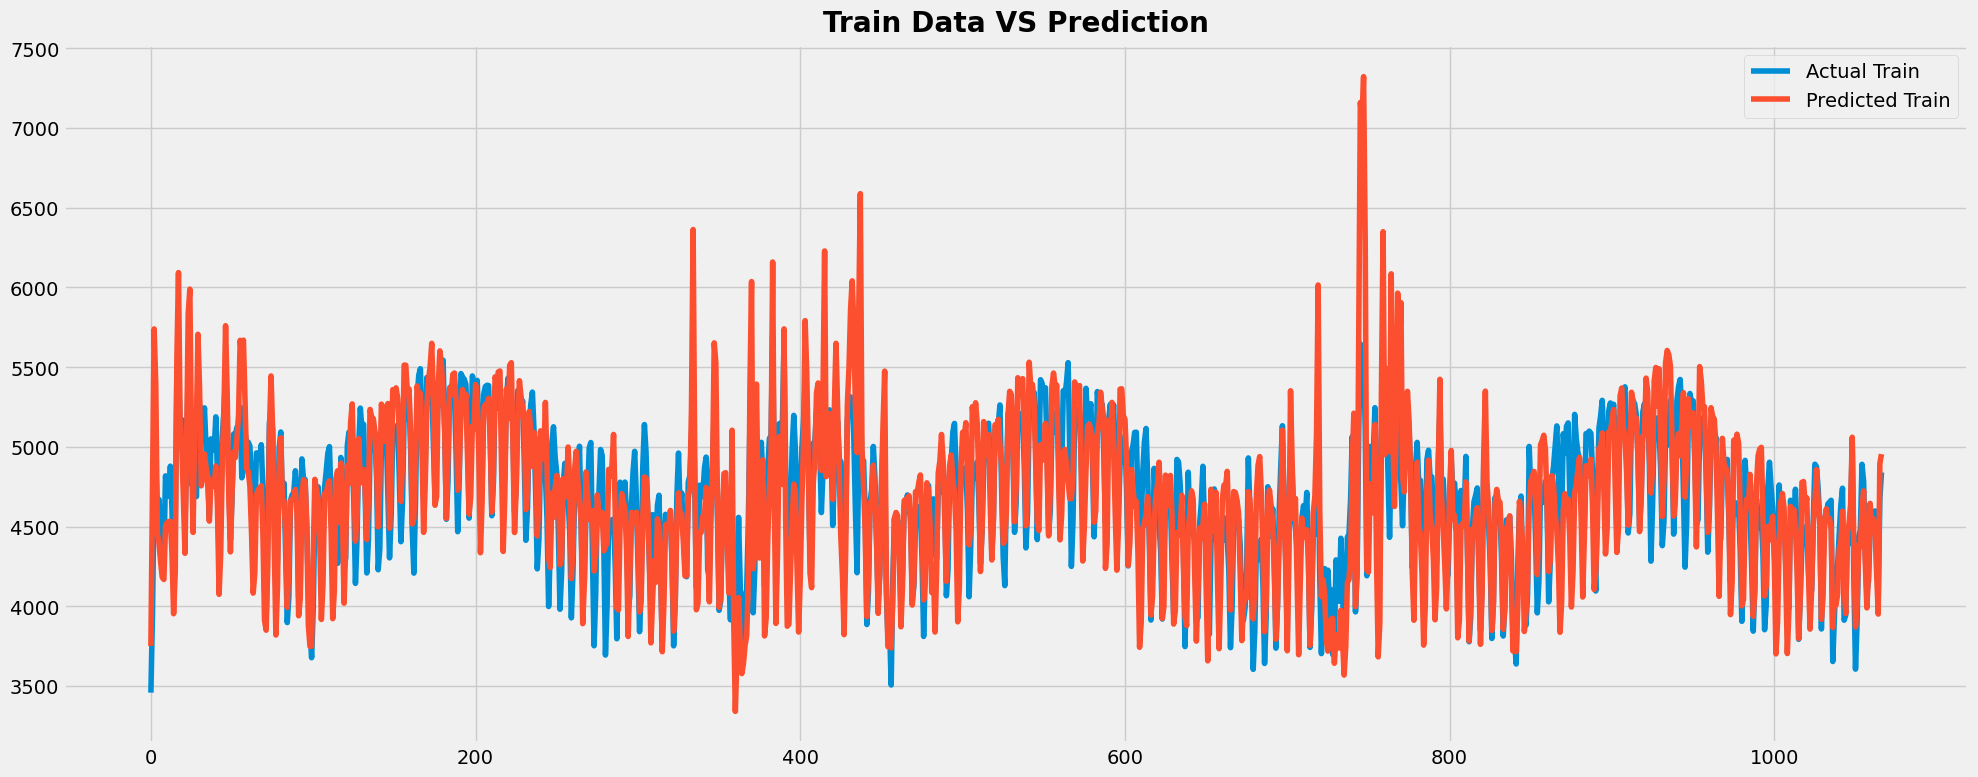

In [21]:
# plot expected vs actual
plt.figure(figsize=(20, 8))
plt.plot(y_pred_train.yhat, label='Actual Train')
plt.plot(y_train.y, label='Predicted Train')
plt.title('Train Data VS Prediction')
plt.legend();

In [22]:
# use the model to make a forecast
y_pred_test = model.predict(y_test)
# summarize the forecast
y_pred_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-12-03,4816.198348,4427.805236,5155.214138
1,2014-12-04,4805.010412,4429.281263,5162.449825
2,2014-12-05,4952.554465,4580.941174,5308.630520
3,2014-12-06,4487.625055,4149.038927,4839.541906
4,2014-12-07,3943.323837,3569.472093,4322.807120


In [23]:
print(
    f'Mean Absolute Error For Test Data Is: {mae(y_test.y, y_pred_test.yhat)}')
print(
    f'Summetric Mean Absolute Error Percentage For Test Data Is: {smape(y_test.y, y_pred_test.yhat)}')

Mean Absolute Error For Test Data Is: 143.85042754537002
Summetric Mean Absolute Error Percentage For Test Data Is: 3.395068484733427


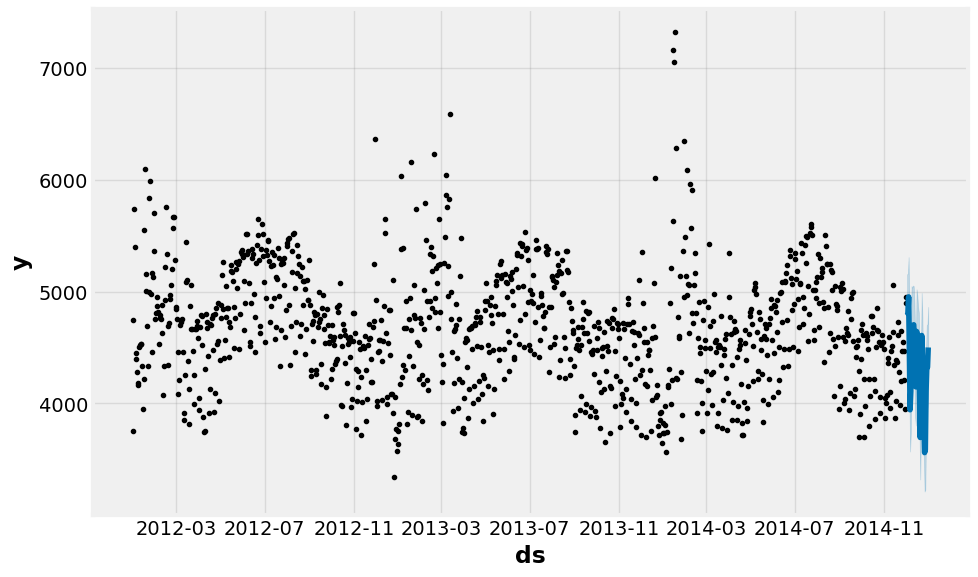

In [24]:
# plot forecast
model.plot(y_pred_test);

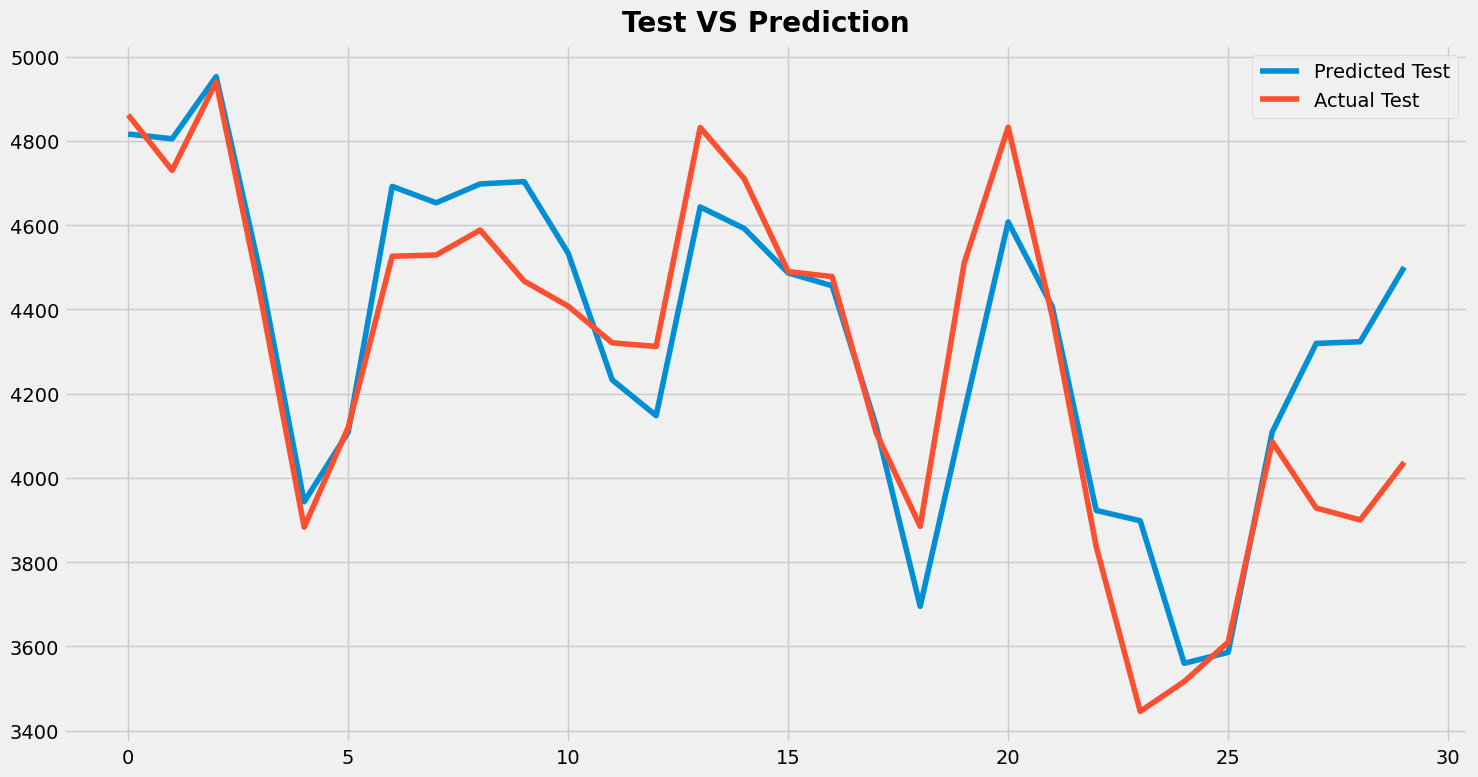

In [25]:
# plot expected vs actual
plt.figure(figsize=(15, 8))
plt.plot(y_pred_test.yhat, label='Predicted Test')
plt.plot(y_test.reset_index()['y'], label='Actual Test')
plt.title('Test VS Prediction')
plt.legend();

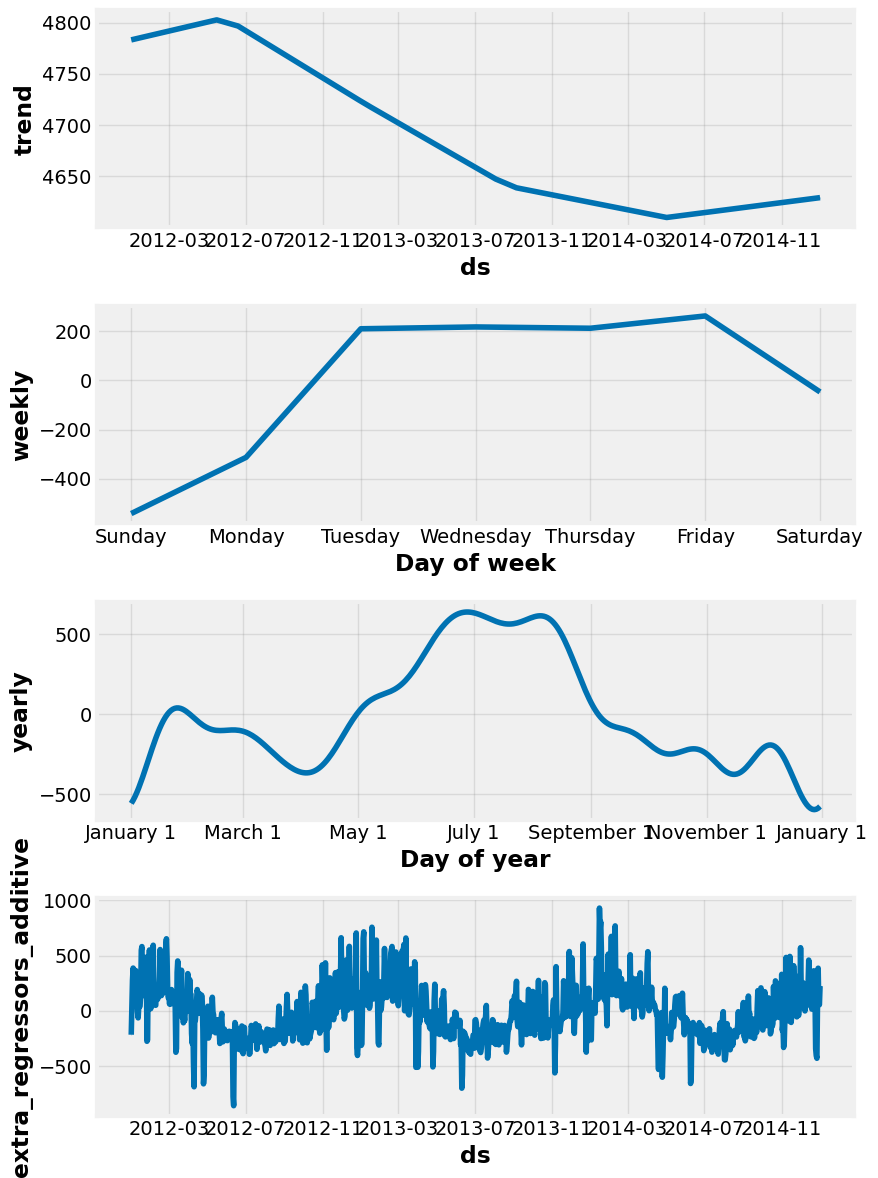

In [26]:
model.plot_components(model.predict(df));

In [28]:
# forecast

forecast_df = model.make_future_dataframe(periods=30)

In [30]:
df.columns

Index(['ds', 'y', 'Temperature', 'Holiday'], dtype='object')

In [33]:
# Add exog data
forecast_df[['Temperature', 'Holiday']] = df[['Temperature', 'Holiday']]

In [39]:
forecast_df.head()

,ds,Temperature,Holiday
0,2012-01-01,21.047727,1
1,2012-01-02,26.578125,1
2,2012-01-03,31.751042,1
3,2012-01-04,24.567708,0
4,2012-01-05,18.191667,0


In [48]:
forecast = model.predict(forecast_df)

In [49]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday,Holiday_lower,Holiday_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,4783.130284,3066.598396,3817.727152,4783.130284,4783.130284,-440.80131,-440.80131,-440.80131,224.736373,...,-540.269826,-540.269826,-540.269826,-568.645818,-568.645818,-568.645818,0.0,0.0,0.0,3458.149703
1,2012-01-02,4783.273589,3587.785465,4329.637515,4783.273589,4783.273589,-440.80131,-440.80131,-440.80131,480.410297,...,-312.376610,-312.376610,-312.376610,-551.839522,-551.839522,-551.839522,0.0,0.0,0.0,3958.666443
2,2012-01-03,4783.416893,4375.430801,5117.212267,4783.416893,4783.416893,-440.80131,-440.80131,-440.80131,719.557636,...,209.494466,209.494466,209.494466,-531.303870,-531.303870,-531.303870,0.0,0.0,0.0,4740.363814
3,2012-01-04,4783.560198,4500.999215,5240.067866,4783.560198,4783.560198,0.00000,0.00000,0.00000,387.467412,...,216.902055,216.902055,216.902055,-507.329867,-507.329867,-507.329867,0.0,0.0,0.0,4880.599798
4,2012-01-05,4783.703502,4258.471540,4964.876848,4783.703502,4783.703502,0.00000,0.00000,0.00000,92.698813,...,211.622953,211.622953,211.622953,-480.266323,-480.266323,-480.266323,0.0,0.0,0.0,4607.758945
